In [1]:
import numpy as np
import numpy.linalg as la
import pyopencl as cl
import pyopencl.array as cl_array
from tqdm import tqdm
import time
from contextlib import contextmanager
from functools import reduce
import math
from pprint import pprint
import matplotlib.pyplot as plt
import sys
import threading

In [2]:
platforms = cl.get_platforms()

def get_platform_info(platform):
    keys = [
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "HOST_TIMER_RESOLUTION",
        "NAME",
        "NUMERIC_VERSION",
        "PROFILE",
        "VENDOR",
        "VERSION",
    ]
    info = {}
    for key in keys:
        try:
            value = platform.get_info(getattr(cl.platform_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    for key in ("extensions",):
        values = info.get(key, None)
        if values:
            values = values.split(" ")
            values = [v.strip() for v in values]
            values = [v for v in values if len(v) > 0]
            info[key] = set(values)
    return info

platform_infos = list(map(get_platform_info, platforms))
if len(platforms) > 1:
    print(f"> Listing platforms ({len(platforms)})")
    pprint(platform_infos)

platform_index = 0
platform = platforms[platform_index]
platform_info = platform_infos[platform_index]

print(f"> Selected platform ({platform_index})")
pprint(platform_info)

def get_device_info(device):
    keys = [
        "ADDRESS_BITS",
        "ATOMIC_FENCE_CAPABILITIES",
        "ATOMIC_MEMORY_CAPABILITIES",
        "ATTRIBUTE_ASYNC_ENGINE_COUNT_NV",
        "AVAILABLE",
        "AVAILABLE_ASYNC_QUEUES_AMD",
        "BOARD_NAME_AMD",
        "BUILT_IN_KERNELS",
        "BUILT_IN_KERNELS_WITH_VERSION",
        "COMPILER_AVAILABLE",
        "COMPUTE_CAPABILITY_MAJOR_NV",
        "COMPUTE_CAPABILITY_MINOR_NV",
        "DEVICE_ENQUEUE_CAPABILITIES",
        "DOUBLE_FP_CONFIG",
        "DRIVER_VERSION",
        "ENDIAN_LITTLE",
        "ERROR_CORRECTION_SUPPORT",
        "EXECUTION_CAPABILITIES",
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "EXT_MEM_PADDING_IN_BYTES_QCOM",
        "GENERIC_ADDRESS_SPACE_SUPPORT",
        "GFXIP_MAJOR_AMD",
        "GFXIP_MINOR_AMD",
        "GLOBAL_FREE_MEMORY_AMD",
        "GLOBAL_MEM_CACHELINE_SIZE",
        "GLOBAL_MEM_CACHE_SIZE",
        "GLOBAL_MEM_CACHE_TYPE",
        "GLOBAL_MEM_CHANNELS_AMD",
        "GLOBAL_MEM_CHANNEL_BANKS_AMD",
        "GLOBAL_MEM_CHANNEL_BANK_WIDTH_AMD",
        "GLOBAL_MEM_SIZE",
        "GLOBAL_VARIABLE_PREFERRED_TOTAL_SIZE",
        "GPU_OVERLAP_NV",
        "HALF_FP_CONFIG",
        "HOST_UNIFIED_MEMORY",
        "ILS_WITH_VERSION",
        "IL_VERSION",
        "IMAGE2D_MAX_HEIGHT",
        "IMAGE2D_MAX_WIDTH",
        "IMAGE3D_MAX_DEPTH",
        "IMAGE3D_MAX_HEIGHT",
        "IMAGE3D_MAX_WIDTH",
        "IMAGE_BASE_ADDRESS_ALIGNMENT",
        "IMAGE_MAX_ARRAY_SIZE",
        "IMAGE_MAX_BUFFER_SIZE",
        "IMAGE_PITCH_ALIGNMENT",
        "IMAGE_SUPPORT",
        "INTEGRATED_MEMORY_NV",
        "KERNEL_EXEC_TIMEOUT_NV",
        "LINKER_AVAILABLE",
        "LOCAL_MEM_BANKS_AMD",
        "LOCAL_MEM_SIZE",
        "LOCAL_MEM_SIZE_PER_COMPUTE_UNIT_AMD",
        "LOCAL_MEM_TYPE",
        "MAX_ATOMIC_COUNTERS_EXT",
        "MAX_CLOCK_FREQUENCY",
        "MAX_COMPUTE_UNITS",
        "MAX_CONSTANT_ARGS",
        "MAX_CONSTANT_BUFFER_SIZE",
        "MAX_GLOBAL_VARIABLE_SIZE",
        "MAX_MEM_ALLOC_SIZE",
        "MAX_NUM_SUB_GROUPS",
        "MAX_ON_DEVICE_EVENTS",
        "MAX_ON_DEVICE_QUEUES",
        "MAX_PARAMETER_SIZE",
        "MAX_PIPE_ARGS",
        "MAX_READ_IMAGE_ARGS",
        "MAX_READ_WRITE_IMAGE_ARGS",
        "MAX_SAMPLERS",
        "MAX_WORK_GROUP_SIZE",
        "MAX_WORK_GROUP_SIZE_AMD",
        "MAX_WORK_ITEM_DIMENSIONS",
        "MAX_WORK_ITEM_SIZES",
        "MAX_WRITE_IMAGE_ARGS",
        "MEM_BASE_ADDR_ALIGN",
        "ME_VERSION_INTEL",
        "MIN_DATA_TYPE_ALIGN_SIZE",
        "NAME",
        "NATIVE_VECTOR_WIDTH_CHAR",
        "NATIVE_VECTOR_WIDTH_DOUBLE",
        "NATIVE_VECTOR_WIDTH_FLOAT",
        "NATIVE_VECTOR_WIDTH_HALF",
        "NATIVE_VECTOR_WIDTH_INT",
        "NATIVE_VECTOR_WIDTH_LONG",
        "NATIVE_VECTOR_WIDTH_SHORT",
        "NON_UNIFORM_WORK_GROUP_SUPPORT",
        "NUMERIC_VERSION",
        "NUM_SIMULTANEOUS_INTEROPS_INTEL",
        "OPENCL_C_ALL_VERSIONS",
        "OPENCL_C_FEATURES",
        "OPENCL_C_VERSION",
        "PAGE_SIZE_QCOM",
        "PARENT_DEVICE",
        "PARTITION_AFFINITY_DOMAIN",
        "PARTITION_MAX_SUB_DEVICES",
        "PARTITION_PROPERTIES",
        "PARTITION_TYPE",
        "PCIE_ID_AMD",
        "PCI_BUS_ID_NV",
        "PCI_DOMAIN_ID_NV",
        "PCI_SLOT_ID_NV",
        "PIPE_MAX_ACTIVE_RESERVATIONS",
        "PIPE_MAX_PACKET_SIZE",
        "PIPE_SUPPORT",
        "PLATFORM",
        "PREFERRED_CONSTANT_BUFFER_SIZE_AMD",
        "PREFERRED_GLOBAL_ATOMIC_ALIGNMENT",
        "PREFERRED_INTEROP_USER_SYNC",
        "PREFERRED_LOCAL_ATOMIC_ALIGNMENT",
        "PREFERRED_PLATFORM_ATOMIC_ALIGNMENT",
        "PREFERRED_VECTOR_WIDTH_CHAR",
        "PREFERRED_VECTOR_WIDTH_DOUBLE",
        "PREFERRED_VECTOR_WIDTH_FLOAT",
        "PREFERRED_VECTOR_WIDTH_HALF",
        "PREFERRED_VECTOR_WIDTH_INT",
        "PREFERRED_VECTOR_WIDTH_LONG",
        "PREFERRED_VECTOR_WIDTH_SHORT",
        "PREFERRED_WORK_GROUP_SIZE_AMD",
        "PREFERRED_WORK_GROUP_SIZE_MULTIPLE",
        "PRINTF_BUFFER_SIZE",
        "PROFILE",
        "PROFILING_TIMER_OFFSET_AMD",
        "PROFILING_TIMER_RESOLUTION",
        "QUEUE_ON_DEVICE_MAX_SIZE",
        "QUEUE_ON_DEVICE_PREFERRED_SIZE",
        "QUEUE_ON_DEVICE_PROPERTIES",
        "QUEUE_ON_HOST_PROPERTIES",
        "QUEUE_PROPERTIES",
        "REFERENCE_COUNT",
        "REGISTERS_PER_BLOCK_NV",
        "SIMD_INSTRUCTION_WIDTH_AMD",
        "SIMD_PER_COMPUTE_UNIT_AMD",
        "SIMD_WIDTH_AMD",
        "SIMULTANEOUS_INTEROPS_INTEL",
        "SINGLE_FP_CONFIG",
        "SPIR_VERSIONS",
        "SUB_GROUP_INDEPENDENT_FORWARD_PROGRESS",
        "SVM_CAPABILITIES",
        "THREAD_TRACE_SUPPORTED_AMD",
        "TOPOLOGY_AMD",
        "TYPE",
        "VENDOR",
        "VENDOR_ID",
        "VERSION",
        "WARP_SIZE_NV",
        "WAVEFRONT_WIDTH_AMD",
        "WORK_GROUP_COLLECTIVE_FUNCTIONS_SUPPORT",
    ]
    info = {}
    for key in keys:
        try:
            value = device.get_info(getattr(cl.device_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    for key in ("extensions",):
        values = info.get(key, None)
        if values:
            values = values.split(" ")
            values = [v.strip() for v in values]
            values = [v for v in values if len(v) > 0]
            info[key] = set(values)
    return info

devices = platform.get_devices()
device_infos = list(map(get_device_info, devices))
if len(devices) > 1:
    print(f"> Listing devices ({len(devices)})")
    pprint(device_infos)

device_index = 0
device = devices[device_index]
device_info = device_infos[device_index]

print(f"> Selected device ({device_index})")
pprint(device_info)

context = cl.Context(devices=[device])

> Selected platform (0)
{'extensions': {'cl_amd_event_callback',
                'cl_amd_offline_devices',
                'cl_khr_d3d10_sharing',
                'cl_khr_d3d11_sharing',
                'cl_khr_dx9_media_sharing',
                'cl_khr_icd'},
 'host_timer_resolution': 100,
 'name': 'AMD Accelerated Parallel Processing',
 'profile': 'FULL_PROFILE',
 'vendor': 'Advanced Micro Devices, Inc.',
 'version': 'OpenCL 2.1 AMD-APP (3628.0)'}
> Selected device (0)
{'address_bits': 64,
 'available': 1,
 'available_async_queues_amd': 2,
 'board_name_amd': 'AMD Radeon(TM) Graphics',
 'built_in_kernels': '',
 'compiler_available': 1,
 'double_fp_config': 63,
 'driver_version': '3628.0 (PAL,LC)',
 'endian_little': 1,
 'error_correction_support': 0,
 'execution_capabilities': 1,
 'extensions': {'cl_amd_copy_buffer_p2p',
                'cl_amd_device_attribute_query',
                'cl_amd_media_ops',
                'cl_amd_media_ops2',
                'cl_amd_planar_yuv',
       

In [3]:
class NanoTimer:
    def __init__(self):
        self.start_ns = None
        self.end_ns = None
    
    def __enter__(self):
        self.start_ns = time.time_ns()
        return self

    def __exit__(self, *args):
        self.end_ns = time.time_ns()        

    def get_delta_ns(self):
        return self.end_ns - self.start_ns

In [4]:
flops_per_cell = 3
compute_complexity = 256
is_wrap_around = True

if is_wrap_around:
    program_source = f"""
        __kernel void curl(__global const float *X, __global float *Y, int Nx, int Ny, int Nz) {{
            int x = get_global_id(0);
            int y = get_global_id(1);
            int z = get_global_id(2);
    
            if (x >= Nx) return;
            if (y >= Ny) return;
            if (z >= Nz) return;
    
            const int n_dims = 3;
            int i = n_dims*(z + y*Nz + x*Nz*Ny);
            int iz = n_dims*(((z+1) % Nz) + y*Nz + x*Nz*Ny);
            int iy = n_dims*(z + ((y+1) % Ny)*Nz + x*Nz*Ny);
            int ix = n_dims*(z + y*Nz + ((x+1) % Nx)*Nz*Ny);

            float dEz_dy = X[i+2]-X[iy+2];
            float dEy_dz = X[i+1]-X[iz+1];
            float dEx_dz = X[i+0]-X[iz+0];
            float dEz_dx = X[i+2]-X[ix+2];
            float dEy_dx = X[i+1]-X[ix+1]; 
            float dEx_dy = X[i+0]-X[iy+0];

            float dEx = dEz_dy-dEy_dz;
            float dEy = dEx_dz-dEz_dx;
            float dEz = dEy_dx-dEx_dy;

            float cEx = 0.0;
            float cEy = 0.0;
            float cEz = 0.0;

            int compute_complexity = {compute_complexity};
            if (i % 12 == 0) {{
                compute_complexity -= 1;
            }}
    
            for (int j = 0; j < compute_complexity; j++) {{
                cEx += dEx;
                cEy += dEy;
                cEz += dEz;
            }}
            Y[i+0] += cEx;
            Y[i+1] += cEy;
            Y[i+2] += cEz;
        }}
    """
else:
    program_source = f"""
        __kernel void curl(__global const float *X, __global float *Y, int Nx, int Ny, int Nz) {{
            int x = get_global_id(0);
            int y = get_global_id(1);
            int z = get_global_id(2);
    
            if (x >= (Nx-1)) return;
            if (y >= (Ny-1)) return;
            if (z >= (Nz-1)) return;
    
            const int n_dims = 3;
            int i = n_dims*(z + y*Nz + x*Nz*Ny);
            int iz = n_dims*((z+1) + y*Nz + x*Nz*Ny);
            int iy = n_dims*(z + (y+1)*Nz + x*Nz*Ny);
            int ix = n_dims*(z + y*Nz + (x+1)*Nz*Ny);
    
            for (int j = 0; j < {compute_complexity}; j++) {{
                Y[i+0] += (X[i+2]-X[iy+2]) - (X[i+1]-X[iz+1]);
                Y[i+1] += (X[i+0]-X[iz+0]) - (X[i+2]-X[ix+2]);
                Y[i+2] += (X[i+1]-X[ix+1]) - (X[i+0]-X[iy+0]);
            }}
        }}
    """

gpu_program = cl.Program(context, program_source).build()

C:\Users\acidi\Coding\Projects\wgpu_compute_experiments\pyopencl\venv\Lib\site-packages\pyopencl\cache.py:496: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


In [5]:
max_compute_units = device_info["max_compute_units"]
workgroups_per_compute_unit = 2048
max_workgroup_threads = device_info["max_work_group_size"]
max_mem_alloc_size = device_info["max_mem_alloc_size"]

sizeof_type = 4
max_global_threads = max_compute_units*workgroups_per_compute_unit*max_workgroup_threads
max_global_threads = min(max_global_threads*sizeof_type, max_mem_alloc_size) // sizeof_type
max_global_threads = (max_global_threads//max_workgroup_threads) * max_workgroup_threads
print(max_global_threads, max_workgroup_threads)

rng = np.random.default_rng()
# grid_size = (32, 128, 256)
grid_size = (17, 107, 128)
n_dims = 3
data_shape = grid_size + (n_dims,)
# workgroup_size = (1,1,256)
workgroup_size = (1,2,128)
max_workgroup_size = device_info["max_work_group_size"]
workgroup_size_count = reduce(lambda x,y: x*y, workgroup_size, 1)
assert(workgroup_size_count <= max_workgroup_size)

if is_wrap_around:
    actual_grid_size = grid_size
else:
    actual_grid_size = [x-1 for x in grid_size]
dispatch_size = [math.ceil(x/y) for x,y in zip(actual_grid_size, workgroup_size)]
# assert(all([x % y == 0 for x,y in zip(grid_size, workgroup_size)]))
global_size = [x*y for x,y in zip(dispatch_size, workgroup_size)]
total_cells = reduce(lambda x,y: x*y, actual_grid_size, n_dims)

print("=== Parameters ===")
print(f"is_wrap_around={is_wrap_around}")
print(f"grid_size={grid_size}")
print(f"actual_grid_size={actual_grid_size}")
print(f"workgroup_size={workgroup_size}")
print(f"dispatch_size={dispatch_size}")
print(f"global_size={global_size}")
print(f"total_cells={total_cells}")

warmup_loops = 16
total_loops = 128
gpu_curl = gpu_program.curl

x_cpu = rng.random(data_shape, dtype=np.float32) % 1.034
y_cpu = np.zeros(data_shape, dtype=np.float32)

print("=== GPU ===")
with cl.CommandQueue(context) as command_queue:
    with NanoTimer() as timer:
        x_gpu = cl_array.to_device(command_queue, x_cpu)
        y_gpu = cl_array.to_device(command_queue, y_cpu)
    gpu_transmit_ns = timer.get_delta_ns()
    print(f"gpu_transmit={gpu_transmit_ns*1e-6:.3f} ms")

class ReadbackBuffer:
    def __init__(self, index, context, shape, dtype):
        with cl.CommandQueue(context) as command_queue:
            self.buffer = cl_array.zeros(command_queue, shape, dtype)
        self.index = index
        self.context = context
        self.shape = shape
        self.data = np.zeros(shape, dtype=dtype)
        self.dtype = dtype
        self.free_ev = threading.Event()
        self.work_ev = threading.Event()
        self.free_ev.set()
        self.work_ev.clear()
        self.is_closed = False
        self.thread = threading.Thread(target=self._runner, args=[])
        self.thread.start()

    def _runner(self):
        while True:
            self.work_ev.wait()
            if self.is_closed:
                break
            self.work_ev.clear()
            # crash now occurs???
            #with cl.CommandQueue(self.context) as command_queue:
                #_, read_ev = self.buffer.get_async(queue=command_queue, ary=self.data)
                #read_ev.wait()
                # _ = self.buffer.get(queue=command_queue, ary=self.data)
            self.free_ev.set()

    def wait(self):
        assert not self.is_closed
        self.free_ev.wait()

    def enqueue(self):
        assert not self.is_closed
        self.free_ev.clear()
        self.work_ev.set()

    def terminate(self):
        if self.is_closed or self.thread == None:
            return
        self.is_closed = True
        self.work_ev.set()
        self.thread.join()
        self.thread = None

    def __del__(self):
        self.terminate()

class ReadbackBuffers:
    def __init__(self, context, total, shape, dtype):
        self.context = context
        self.shape = shape
        self.total = total
        self.dtype = dtype
        self.read_index = 0
        self.buffers = [ReadbackBuffer(index, context, shape, dtype) for index in range(total)]

    def get_buffer(self):
        buffer = self.buffers[self.read_index]
        self.read_index = (self.read_index + 1) % self.total
        return buffer

    def join(self):
        _ = [buffer.wait() for buffer in self.buffers]

y_gpu_readback_buffers = ReadbackBuffers(context, 8, (32,), y_cpu.dtype)
transfer_size = y_gpu_readback_buffers.buffers[0].data.data.nbytes

with cl.CommandQueue(context) as command_queue:
    with NanoTimer() as timer:
        for _ in tqdm(range(warmup_loops)):
            gpu_curl(
                command_queue, 
                global_size, workgroup_size,
                x_gpu.data, y_gpu.data,
                *[np.int32(v) for v in grid_size],
            )
            command_queue.flush()
        command_queue.finish()
    gpu_warmup_ns = timer.get_delta_ns()
    print(f"gpu_warmup={gpu_warmup_ns*1e-6:.3f} ms")

kernel_events = []
with cl.CommandQueue(context, properties=cl.command_queue_properties.PROFILING_ENABLE) as command_queue:
    with NanoTimer() as timer:
        for i in range(total_loops):
            y_gpu_readback_buffer = y_gpu_readback_buffers.get_buffer()
            y_gpu_readback_buffer.wait()
            ev = gpu_curl(
                command_queue, 
                global_size, workgroup_size,
                x_gpu.data, y_gpu.data,
                *[np.int32(v) for v in grid_size],
            )
            kernel_events.append(ev)
            #ev.wait()
            cl.enqueue_copy(command_queue, y_gpu_readback_buffer.buffer.data, y_gpu.data, byte_count=transfer_size)
            y_gpu_readback_buffer.enqueue()
            command_queue.flush()
        command_queue.finish()
        _ = [ev.wait() for ev in kernel_events]
        y_gpu_readback_buffers.join()
    gpu_submit_ns = timer.get_delta_ns()
    print(f"gpu_queue_command={gpu_submit_ns*1e-6:.3f} ms")

with cl.CommandQueue(context) as command_queue:
    with NanoTimer() as timer:
        y_gpu_out = np.zeros(y_cpu.shape, dtype=y_cpu.dtype)
        y_gpu.get(queue=command_queue, ary=y_gpu_out)
    gpu_receive_ns = timer.get_delta_ns()
    print(f"gpu_receive={gpu_receive_ns*1e-6:.3f} ms")

gpu_net_ns = gpu_submit_ns + gpu_receive_ns
gpu_pass_ns = gpu_submit_ns / total_loops
gpu_cell_rate = total_cells / (gpu_pass_ns*1e-9)
gpu_flop_rate = gpu_cell_rate * flops_per_cell * compute_complexity

print(f"gpu_net_time={gpu_net_ns*1e-6:.3f} ms")
print(f"gpu_pass_time={gpu_pass_ns*1e-6:.3f} ms")
print(f"gpu_cell_rate={gpu_cell_rate*1e-6:.3f} M/s")
print(f"gpu_flops={gpu_flop_rate*1e-9:.3f} GFlops")

3145728 256
=== Parameters ===
is_wrap_around=True
grid_size=(17, 107, 128)
actual_grid_size=(17, 107, 128)
workgroup_size=(1, 2, 128)
dispatch_size=[17, 54, 1]
global_size=[17, 108, 128]
total_cells=698496
=== GPU ===
gpu_transmit=2.002 ms


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 7968.28it/s]

gpu_warmup=14.481 ms
gpu_queue_command=39.011 ms
gpu_receive=1.999 ms
gpu_net_time=41.010 ms
gpu_pass_time=0.305 ms
gpu_cell_rate=2291.865 M/s
gpu_flops=1760.152 GFlops


['queued', 'submit', 'start', 'complete', 'end']


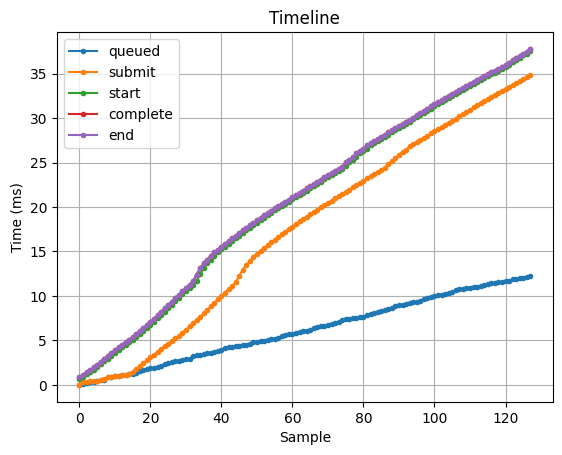

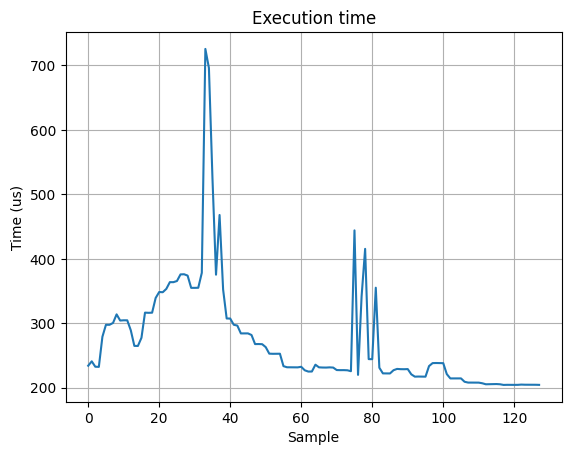

exec_median=233.880us


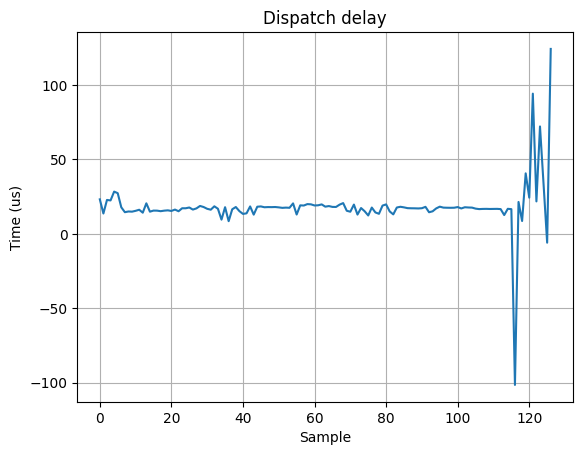

dispatch_delay_median=17.360us


In [6]:
def get_profiling_info(ev):
    keys = [
        "COMPLETE",
        "END",
        "QUEUED",
        "START",
        "SUBMIT",
    ]
    return { key.lower(): ev.get_profiling_info(getattr(cl.profiling_info, key)) for key in keys }
    
ns_per_tick = device_info["profiling_timer_resolution"]

profile_info = [get_profiling_info(ev) for ev in kernel_events]
event_types = list(profile_info[0].items())
event_types = sorted(event_types, key=lambda x: x[1])
event_types = [k for k,v in event_types]
print(event_types)

total_events = len(event_types)
N = len(profile_info)
Y = np.zeros((total_events, N), dtype=np.float64)
X = np.arange(len(profile_info))

for j, key in enumerate(event_types):
    y = Y[j]
    for i, info in enumerate(profile_info):
        time_ticks = info[key]
        time_ns = ns_per_tick*time_ticks
        y[i] = time_ns

Y -= np.min(Y)

plt.figure()
# i = slice(64, 64+10)
i = slice(0, N)
for j, key in enumerate(event_types):
    # if j <= 1: continue
    plt.plot(X[i], Y[j,i] * 1e-6, label=key, marker=".")
plt.grid(True)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Time (ms)")
plt.title("Timeline")
plt.show()

exec_ns = Y[3] - Y[2]
plt.figure()
plt.plot(exec_ns*1e-3)
plt.grid()
plt.xlabel("Sample")
plt.ylabel(f"Time (us)")
plt.title("Execution time")
plt.show()

print(f"exec_median={np.median(exec_ns)*1e-3:.3f}us")

delay_dispatch_ns = Y[2,1:] - Y[3,:-1] 
plt.figure()
plt.plot(delay_dispatch_ns*1e-3)
plt.grid()
plt.xlabel("Sample")
plt.ylabel(f"Time (us)")
plt.title("Dispatch delay")
plt.show()

# print(f"dispatch_delay_median={np.median(delay_dispatch_ns)*1e-3:.3f}us")
print(f"dispatch_delay_median={np.median(delay_dispatch_ns)*1e-3:.3f}us")